In [288]:
#! wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
#! tar -zxvf 101_ObjectCategories.tar.gz

In [289]:
import numpy as np
import seaborn as sns

In [290]:
from imutils import paths
import matplotlib.pyplot as plt

import numpy as np
import cv2
import os

In [291]:
all_categories = os.listdir("101_ObjectCategories")
print(all_categories)

['gerenuk', 'hawksbill', 'headphone', 'ant', 'butterfly', 'lamp', 'strawberry', 'water_lilly', 'chandelier', 'dragonfly', 'crab', 'pagoda', 'dollar_bill', 'emu', 'inline_skate', 'platypus', 'dalmatian', 'cup', 'airplanes', 'joshua_tree', 'cougar_body', 'grand_piano', 'trilobite', 'brontosaurus', 'wild_cat', 'pigeon', 'dolphin', 'soccer_ball', 'wrench', 'scorpion', 'flamingo_head', 'nautilus', 'accordion', 'cougar_face', 'pyramid', 'camera', 'barrel', 'schooner', 'cellphone', 'panda', 'revolver', 'lobster', 'menorah', 'lotus', 'stapler', 'crocodile', 'chair', 'helicopter', 'minaret', 'starfish', 'ceiling_fan', 'ketch', 'mayfly', 'wheelchair', 'bass', 'yin_yang', 'crocodile_head', 'saxophone', 'beaver', 'mandolin', 'bonsai', 'Leopards', 'car_side', 'ibis', 'electric_guitar', 'kangaroo', 'stegosaurus', 'ferry', 'snoopy', 'umbrella', 'rhino', 'okapi', 'watch', 'brain', 'gramophone', 'scissors', 'rooster', 'cannon', 'binocular', 'anchor', 'octopus', 'buddha', 'laptop', 'windsor_chair', 'hed

In [292]:
LABELS = ["Faces", "Leopards", "Motorbikes", "airplanes","accordion","ant","buddha",'laptop',
          'elephant','anchor']

LABELS = ["Faces", "Leopards", "Motorbikes", "airplanes"]

imagePaths = list(paths.list_images("101_ObjectCategories"))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
 
    #if label not in LABELS:
    #    continue
 
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (96, 96))
 
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
print("image loaded")

image loaded


(96, 96, 3)


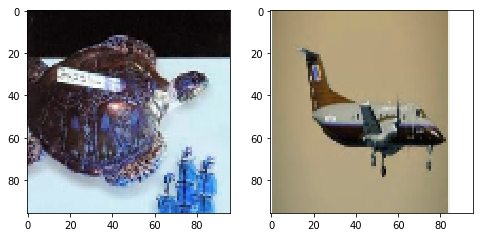

In [293]:
print(data[0].shape)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(data[123])
plt.subplot(1,2,2)
plt.imshow(data[1234])

In [294]:
data = np.array(data) / 255

In [295]:
data.shape

(9144, 96, 96, 3)

In [296]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

In [297]:
binarizer = LabelBinarizer()

In [298]:
labels = binarizer.fit_transform(labels)

In [299]:
from sklearn.model_selection import train_test_split

In [300]:
x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size=0.3)

In [301]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dropout,Dense, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [302]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model = Sequential()
model.add(Conv2D(16,(3,3), strides=(2,2),padding="same",activation="relu",input_shape=(96,96,3)))
model.add(Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.3))
model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
model.add(Conv2D(256,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dense(102, activation="softmax"))

model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

In [309]:
model = Sequential()
model.add(Conv2D(64,(7,7),padding="valid",kernel_initializer="he_normal",use_bias=False, activation="relu"))
model.add(MaxPool2D((3,3),(2,2)))

model.add(Conv2D(64,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(64,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(64,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(64,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(64,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(64,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))


model.add(Conv2D(128,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(128,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(512,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(128,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(128,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(512,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(128,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(128,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(512,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(128,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(128,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(512,kernel_size=(1,1),activation="relu",padding="valid"))


model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(1024,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(1024,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(1024,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(1024,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(1024,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(256,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(256,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(1024,kernel_size=(1,1),activation="relu",padding="valid"))


model.add(Conv2D(512,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(512,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(2048,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(512,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(512,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(2048,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Conv2D(512,kernel_size=(1,1),activation="relu",padding="valid"))
model.add(Conv2D(512,kernel_size=(3,3),activation="relu",padding="valid"))
model.add(Conv2D(2048,kernel_size=(1,1),activation="relu",padding="valid"))

model.add(Flatten())

#model.add(AveragePooling2D())
model.add(Dense(102,activation="softmax"))

model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

In [310]:
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,
        brightness_range=[0.9,1.15])


datagen.fit(x_train)

In [311]:
directory = f"models/{len(LABELS)}-categories/"
if not os.path.exists(directory):
    os.makedirs(directory)

earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')
mcp_save = ModelCheckpoint(directory + 'model.{epoch:02d}-{val_acc:.2f}.hdf5', save_best_only=True, monitor='val_acc')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

model.fit(x_train,y_train,batch_size=64,epochs=50,validation_data=(x_test,y_test),callbacks=[earlyStopping,mcp_save, reduce_lr_loss])
#model.fit_generator(datagen.flow(x_train,y_train,batch_size=64),epochs=100,validation_data=(x_test,y_test),callbacks=[mcp_save,reduce_lr_loss],steps_per_epoch=len(x_train))

Train on 6400 samples, validate on 2744 samples
Epoch 1/50
 832/6400 [==>...........................] - ETA: 33:17 - loss: 12.9740 - acc: 0.0950

KeyboardInterrupt: 

In [156]:
model.evaluate(x=x_test,y=y_test)

2744/2744 [==============================] - 1s 389us/sample - loss: 3.0745 - acc: 0.6327


[3.074488122678707, 0.63265306]

In [157]:
pred = [LABELS[p.argmax()] for p in model.predict(x_test)]

IndexError: ignored

In [0]:
y_test_oneclass = [LABELS[p.argmax()] for p in y_test]

print(confusion_matrix(y_test_oneclass,pred))

print(classification_report(y_test_oneclass,pred))

In [0]:
from tensorflow.keras.models import load_model

In [0]:
t_model = load_model("model.14-0.09.hdf5")

In [0]:
t_model.evaluate(x_test,y_test)